In [6]:
import random
import pandas as pd
import matplotlib as plt

from transformers import AutoTokenizer
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

In [7]:
train_df = pd.read_csv("./cnn_dailymail/train.csv")
val_df = pd.read_csv("./cnn_dailymail/validation.csv")

In [8]:
val_df.head()

,id,article,highlights
0,61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,21c0bd69b7e7df285c3d1b1cf56d4da925980a68,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,56f340189cd128194b2e7cb8c26bb900e3a848b4,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,00a665151b89a53e5a08a389df8334f4106494c2,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,9f6fbd3c497c4d28879bebebea220884f03eb41a,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [5]:
# Select first 5 rows
val_df_sample = val_df.head(5)

# Save to a .pkl file
val_df_sample.to_pickle("./val_df_sample.pkl")

### Exclude article length outliers

<Axes: >

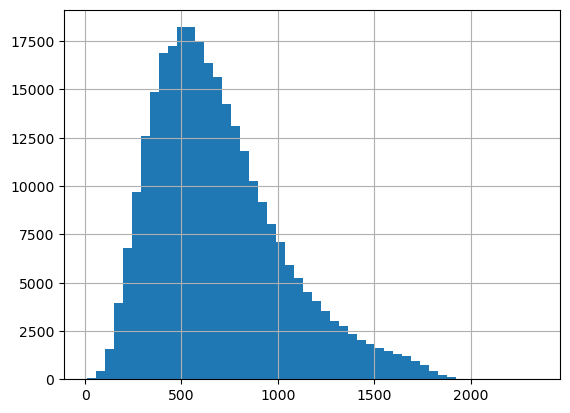

In [57]:
# Create a new column in the dataframe that contains the lengths of the articles
train_df['article_length'] = train_df['article'].apply(lambda x: len(x.split()))

# Plot a histogram of the article lengths
train_df['article_length'].hist(bins=50)

0          37
1          38
2          69
3          53
4          67
         ... 
287108     42
287109    108
287110     56
287111     55
287112     59
Name: highlights_length, Length: 287113, dtype: int64

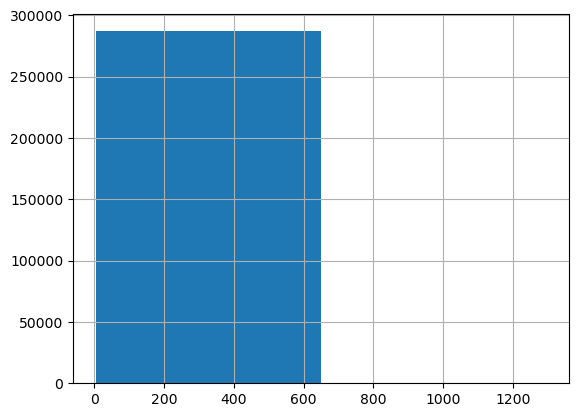

In [64]:
# Create a new column in the dataframe that contains the lengths of the articles
train_df['highlights_length'] = train_df['highlights'].apply(lambda x: len(x.split()))

# Plot a histogram of the article lengths
train_df['highlights_length'].hist(bins=2)
train_df['highlights_length']

In [65]:
print(train_df['article_length'].describe())
print(train_df['highlights_length'].describe())

count    287113.000000
mean        691.869494
std         336.500035
min           8.000000
25%         443.000000
50%         632.000000
75%         877.000000
max        2347.000000
Name: article_length, dtype: float64
count    287113.000000
mean         51.574101
std          21.256336
min           4.000000
25%          38.000000
50%          48.000000
75%          60.000000
max        1296.000000
Name: highlights_length, dtype: float64


In [59]:
# Calculate median and interquartile range of article length
median_length = train_df['article_length'].median()
Q1 = train_df['article_length'].quantile(0.25)
Q3 = train_df['article_length'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for article length
lower_bound = max(0, Q1 - 1.5*IQR) # We take max with 0 to avoid negative lengths
upper_bound = Q3 + 1.5*IQR

# Filter DataFrame to only include articles within bounds
filtered_df = train_df[(train_df['article_length'] >= lower_bound) & 
                       (train_df['article_length'] <= upper_bound)]


In [6]:
# Number of outliers excluded
len(train_df) - len(filtered_df)

7183

### Tokenization

In [35]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [66]:
# Tokenize and encode data

def data_process(data, tokenizer):
    raw_src_iter = iter(data['article'])
    raw_tgt_iter = iter(data['highlights'])
    src_data = []
    tgt_data = []
    for (raw_src, raw_tgt) in zip(raw_src_iter, raw_tgt_iter):
        src_tensor_ = torch.tensor(tokenizer.encode(raw_src, truncation=True, max_length=800), dtype=torch.long)
        tgt_tensor_ = torch.tensor(tokenizer.encode(raw_tgt, truncation=True, max_length=80), dtype=torch.long)
        src_data.append(src_tensor_)
        tgt_data.append(tgt_tensor_)

    # pad the sequences
    src_data = pad_sequence(src_data, batch_first=True, padding_value=tokenizer.pad_token_id)
    tgt_data = pad_sequence(tgt_data, batch_first=True, padding_value=tokenizer.pad_token_id)

    return src_data, tgt_data


train_inputs, train_targets = data_process(filtered_df, tokenizer) # list of (source tensor - (512), target tensor (512))
val_inputs, val_targets = data_process(val_df, tokenizer)

# Saved trained tokenizer training data (around 45 minutes to train)
import pickle

# Save training inputs
with open('train_inputs2.pkl', 'wb') as file:
    pickle.dump(train_inputs, file)
# Save training targets
with open('train_targets2.pkl', 'wb') as file:
    pickle.dump(train_targets, file)

In [10]:
import pickle

# Open the file in binary mode
with open('train_inputs.pkl', 'rb') as file:
    train_inputs = pickle.load(file)
with open('train_targets.pkl', 'rb') as file:
    train_targets = pickle.load(file)

In [11]:
test_batch = train_inputs[:10]
target_batch = train_targets[:10]
print(f'Source shape: {test_batch.shape}') # tensor representation of article's tokens
print(f'Target shape: {target_batch.shape}') # tensor representation of article's targets

Source shape: torch.Size([10, 512])
Target shape: torch.Size([10, 512])


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))

        return outputs, hidden

In [12]:
src = test_batch

INPUT_DIM = tokenizer.vocab_size
EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
DROPOUT = 0.5

print(src.shape) # shape of initial source tensor
embds = nn.Embedding(INPUT_DIM, EMB_DIM)(src)
print(embds.shape) # shape of embeddings for source tensor (one embedding vector of dimension EMB_DIM for each token in each sequence)
outs, hid = nn.GRU(EMB_DIM, ENC_HID_DIM, bidirectional=True, batch_first=True)(embds)
# shape of the output of the last layer of the GRU (the final output), which is (src length, ENC_HID_DIM times 2, since the GRU is bidirectional) for each sequence
print(outs.shape)
print(hid.shape) # shape of the final hidden state of the GRU, which is (number of directions, n_seq, ENC_HID_DIM)
fc = nn.Linear(ENC_HID_DIM*2, DEC_HID_DIM) # linear layer with input and output sizes defined
fc_inp = torch.cat((hid[-2, :, :], hid[-1, :, :]), dim=1) # concatenate forward and backward hidden states for each sequence
fc_act = torch.tanh(fc(fc_inp)) # apply fully connected layer to hidden states, then apply a non-linearity (tanh)
print(fc_act.shape)

# outputs of the decoder - all GRU outputs (both directions concatenated for each token in each sequence), final hidden states of each sequence
outs.shape, fc_act.shape 

torch.Size([10, 512])
torch.Size([10, 512, 256])
torch.Size([10, 512, 1024])
torch.Size([2, 10, 512])
torch.Size([10, 512])


(torch.Size([10, 512, 1024]), torch.Size([10, 512]))

In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.shape[1]
        batch_size = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)

In [14]:
encoder_outs = outs, fc_act # output of the encoder
outputs = encoder_outs[0]
hidden_og = encoder_outs[1]
seq_len = outputs.shape[1] # length of each sequence in the batch (512)
batch_size = outputs.shape[0] # number of sequences in the batch (10)
print(f'Hidden state: {hidden_og.shape}')
print(f'Encoder outputs: {outputs.shape}')
print('----')

hidden = hidden_og.unsqueeze(1).repeat(1,seq_len,1) # repeat the hidden states for each sequence seq_len times
print(f'Hidden state: {hidden.shape}')
print(f'Encoder outputs: {outputs.shape}')
print('----')

attn_inp = torch.cat((hidden, outputs), dim=2)
attn = nn.Linear((ENC_HID_DIM * 2) + DEC_HID_DIM, DEC_HID_DIM) # linear layer that takes computes the energy between the hidden state and each encoder output
energy = torch.tanh(attn(attn_inp))
print(f'Input to energy (concatenated hidden and encoder outputs states): {attn_inp.shape}') 
print(f'Energy result: {energy.shape}') # 512-dimensional vector for each token in each sequence (info on how useful the encoder output is to the hidden state)
print('----')

v = nn.Linear(DEC_HID_DIM, 1, bias=False) # linear layer that transforms energy vector into a value between 0 and 1 for each token in each sequence
energy_vals = v(energy).squeeze(2) # compute how important each encoder output is to the decoder hidden state (squeeze to reduce to 2 dimensions)
print(f'Encoder output - Decoder hidden state energy values: {energy_vals.shape}')
attn_outs = F.softmax(energy_vals, dim=1) # pass through a softmax
print(f'Softmax results (attention outputs): {attn_outs.shape}')

Hidden state: torch.Size([10, 512])
Encoder outputs: torch.Size([10, 512, 1024])
----
Hidden state: torch.Size([10, 512, 512])
Encoder outputs: torch.Size([10, 512, 1024])
----
Input to energy (concatenated hidden and encoder outputs states): torch.Size([10, 512, 1536])
Energy result: torch.Size([10, 512, 512])
----
Encoder output - Decoder hidden state energy values: torch.Size([10, 512])
Softmax results (attention outputs): torch.Size([10, 512])


In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(2)

        encoder_outputs = encoder_outputs.transpose(1,2)
        # print(a.shape, encoder_outputs.shape)
        weighted = torch.bmm(encoder_outputs, a) # context vectors
        weighted = weighted.squeeze(2).unsqueeze(0)

        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        # Squeeze the output tensors from the GRU
        output = output.squeeze(0)
        hidden = hidden.squeeze(0)

        embedded = embedded.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden, a.squeeze(2)

In [16]:
print(src.shape)
attn_outs = attn_outs
print(attn_outs.shape)
outputs = encoder_outs[0]
print(outputs.shape)
# hidden = encoder_outs[1]
print(hidden.shape)
sos_token_id = tokenizer.eos_token_id  # Get the SOS token ID
sos_token_tensor = torch.tensor([sos_token_id] * 10)  # Convert it into a tensor of 10 sos token ids (sos and eos are equivalent in GPT-2 tokenizer)
print(sos_token_tensor.shape) 
print('----')

embd_layer = nn.Embedding(INPUT_DIM, EMB_DIM)
embd_inp = sos_token_tensor.unsqueeze(0) # create an extra dim so this can be an input to the embedding layer
print(embd_inp.shape)
sos_embds = embd_layer(embd_inp) # returns an embedding vector for each token (at this point, 1 token per sequence in the batch)
print(sos_embds.shape)
print('----')

enc_outs = outputs.transpose(1, 2)
print(enc_outs.shape)
attn_outs = attn_outs.unsqueeze(2)
print(attn_outs.shape)
context_vecs = torch.bmm(enc_outs, attn_outs) # weighted sum of the encoder hidden states (weighted by the attention weights) gives the context vectors
print(context_vecs.shape) # the context vector is a summary of the sequence, highlighting some parts of the sequence based on the attention mechanism
print('----')



torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512, 1024])
torch.Size([10, 512, 512])
torch.Size([10])
----
torch.Size([1, 10])
torch.Size([1, 10, 256])
----
torch.Size([10, 1024, 512])
torch.Size([10, 512, 1])
torch.Size([10, 1024, 1])
----


In [17]:
print(sos_embds.shape)
context_vecs = context_vecs.squeeze(2).unsqueeze(0)  # shape becomes (1, 10, 1024)
print(context_vecs.shape)

torch.Size([1, 10, 256])
torch.Size([1, 10, 1024])


In [18]:
hidden_og.unsqueeze(0).shape

torch.Size([1, 10, 512])

In [19]:
rnn_inp = torch.cat((sos_embds, context_vecs), dim=2) # shape becomes (1, 10, 1280)
print(rnn_inp.shape)
rnn = nn.GRU((ENC_HID_DIM * 2) + EMB_DIM, DEC_HID_DIM)
rnn_outs = rnn(rnn_inp, hidden_og.unsqueeze(0))

out = rnn_outs[0].squeeze(0)
hid = rnn_outs[1].squeeze(0)
embeds = sos_embds.squeeze(0)
weighted = context_vecs.squeeze(0)

fc_out = nn.Linear((ENC_HID_DIM * 2) + DEC_HID_DIM + EMB_DIM, INPUT_DIM)
testing = fc_out(torch.cat((out, weighted, embeds), dim=1))
testing.shape

torch.Size([1, 10, 1280])


torch.Size([10, 50257])

In [52]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5, max_len=512):
        # src = [batch size, src len]
        # trg = [batch size, trg len]
        if trg is not None:
            batch_size = trg.shape[0]
            trg_len = trg.shape[1]
        else:
            batch_size = src.shape[0]
            trg_len = max_len  # set a maximum length for the generated sequence
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)

        # first input to the decoder is the <sos> tokens
        input = trg[:, 0] if trg is not None else torch.tensor([tokenizer.bos_token_id]).to(self.device)

        for t in range(1, trg_len):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)

            # place predictions in a tensor holding predictions for each token
            outputs[:, t, :] = output

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            # get the highest predicted token from our predictions
            top1 = output.argmax(1)

            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force and trg is not None else top1
            
        return outputs

In [53]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your parameters
INPUT_DIM = tokenizer.vocab_size
OUTPUT_DIM = tokenizer.vocab_size
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# Initialize attention, encoder, and decoder
attn = Attention(ENC_HID_DIM, DEC_HID_DIM).to(device)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn).to(device)

# Initialize Seq2Seq model
model = Seq2Seq(enc, dec, device).to(device)

# # Move your test batch to the correct device
# test_batch = train_inputs[:10]
# test_batch = test_batch.to(device)

# # You should also supply the target tensor, which you can initially set as the test batch itself
# test_targets = train_targets[:10]

# # Finally, call the model
# output = model(test_batch, test_targets)
# output.shape

In [9]:
# define hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 0.001

# define loss function and optimizer
loss_fn = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# prepare data
train_dataset = TensorDataset(train_inputs[:100], train_targets[:100])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# train the model
model.train()  # set the model to training mode
for epoch in range(NUM_EPOCHS):
    for i, (inputs, targets) in enumerate(train_loader):
        # move inputs and targets to the correct device
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        output = model(inputs, targets)

        # compute the loss
        output = output.view(-1, output.shape[-1])  # flatten the outputs
        targets = targets.view(-1)  # flatten the targets
        loss = loss_fn(output, targets)

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # print loss for every 100 steps
        # if i % 100 == 0:
        print(f'Epoch: {epoch}, Step: {i}, Loss: {loss.item()}')


: 

: 

In [54]:
model_path = './seq2seq1.pt'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [55]:
# Select first 5 rows
val_df_sample = val_df.head(5)
articles = list(val_df_sample['article'])

# Tokenize, pad and move to device
inputs = [torch.tensor(tokenizer.encode(article, truncation=True, max_length=512)).unsqueeze(0) for article in articles]
inputs = [input.to(device) for input in inputs]

# Set model to eval mode
model.eval()

# Loop through each article
for i, input in enumerate(inputs):
    with torch.no_grad():
        # Get model output
        output = model(input)
        
        # Get the predicted tokens
        predicted_tokens = output.argmax(-1)
        
        # Convert the tokens back to words
        predicted_article = tokenizer.decode(predicted_tokens[0])
        
        print(f'Original Article: {articles[i]}')
        print(f'Summarized Article: {predicted_article}')

Original Article: Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films such as the 1956 noir While the City Sleeps died on March 15 at her home in Beverly Hills, California. Forrest, whose birth name was Katherine Feeney, was 86 and had long battled cancer. Her publicist, Judith Goffin, announced the news Thursday. Scroll down for video . Actress: Sally Forrest was in the 1951 Ida Lupino-directed film 'Hard, Fast and Beautiful' (left) and the 1956 Fritz Lang movie 'While the City Sleeps' A San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films including the critical and commercial success Not Wanted, Never Fear and Hard, Fast and Beautiful. Some of Forrest's other film credits included Bannerline, Son of Sinbad, and Excuse My Dust, according to her iMDB page. The page also indicates Forrest was in multiple Climax! and Rawhide television episodes. Forrest appe